# Modelling Credit Risk

Modelling a borrower's credit risk using financial lending data from [Lending Club](https://www.lendingclub.com). Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. 

Summary of how Lending Club works:
IMAGE

Acting as a conservative investor who only wants to invest in loans that have a good chance of being paid off on time. 

To do this need to understand:
* features in the dataset
* experiment with building machine learning models that reliably predict if the loan will be paid off or not

Data dictionary: File 

Lending Club website releases data for all approved and declined loan applications periodically [on their website](https://www.lendingclub.com/info/download-data.action). 

Focusing on the **LoanStats** sheet which describes the approved loans. The approved loans datasets contain information on current loans, completed loans, and defaulted loans. 

**Aim**: build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not.

Focused on approved loans from 2007 to 2011 since good number of loans have already finished. In the datasets for later years, many of the loans are current and still being paid off.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

## Exploring the data

NOTE: dataset has already been reduced in size by removing:
* `desc` column: contains long text explanation for each loan
* `url` column:  contains a link to each loan on Lending Club which can only be accessed with an investor account
* all columns containing more than 50% missing values

In [2]:
loans_2007 = pd.read_csv("loans_2007.csv")

loans_2007.head()

/Users/Roya/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9%,38.0,f,461.73,461.73,3581.120000,3581.12,2538.27,1042.85,0.00,0.00,0.00,Jun-2016,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [3]:
loans_2007.shape

(42538, 52)

## Main functions

The following functions will **transform** and **select** features and then **train and test** using

In [4]:
# def transform_features(df):
#     return df

# def select_features(df):
#     return df[[]]

# def train_and_test(df):

## Feature Engineering


1. Dropping columns that:
    * Leak information from the future (after the loand has already been funded)
    * Don't affect a borrower's ability to pay back a loan (e.g. randomly generated ID value by Lending Club)
    * formatted poorly and needs to be cleaned up
    * requires more data or a lof of porcessing to turn into a useful information
    * contain redundant information 


Going through data 18 columns at a time since there are a total of 52 rows to go through.

Following features need to be removed:
* `id`: randomly generated field by Lending Club for unique identification purposes only
* `member_id`: also a randomly generated field by Lending Club for unique identification purposes only
* `funded_amnt`: leaks data from the future (after the loan is already started to be funded)
* `funded_amnt_inv`: also leaks data from the future (after the loan is already started to be funded)
* `grade`: contains redundant information as the interest rate column (`int_rate`)
* `sub_grade`: also contains redundant information as the interest rate column (int_rate)
* `emp_title`: requires other data and a lot of processing to potentially be useful
* `issue_d`: leaks data from the future (after the loan is already completely funded)

NOTE: Lending Club assigns a grade and a sub-grade based on the borrower's interest rate. While the `grade` and `sub_grade` values are categorical, the `int_rate` column contains continuous values, which are better suited for machine learning.

In [5]:
loans_2007 = loans_2007.drop(['id','member_id', 'funded_amnt', 'funded_amnt_inv', 
                              'grade', 'sub_grade', 'emp_title', 'issue_d'], axis=1)

Next 18 columns, dropping the following:
* `zip_code`: redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible (which only can be used to identify the state the borrower lives in)

The rest are dropped as they leak data from the future (contains information which isn't available to an investor before the loan is fully funded, therefore don't want to include it in the model):
* `out_prncp`
* `out_prncp_inv`
* `total_pymnt`
* `total_pymnt_inv`
* `total_rec_prncp`  


In [6]:
loans_2007 = loans_2007.drop(['zip_code', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 
                              'total_pymnt_inv', 'total_rec_prncp'], axis=1)

Final 18 columns (features), dropping the following as they all leak data from the future (meaning they describe aspects of the loan after it's already been fully funded and started to be paid off by the borrower:
* `total_rec_int`
* `total_rec_late_fee`
* `recoveries`
* `collection_recovery_fee`
* `last_pymnt_d`
* `last_pymnt_amnt`  

In [7]:
loans_2007 = loans_2007.drop(['total_rec_int', 'total_rec_late_fee', 'recoveries', 
                              'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt'], axis=1)

In [8]:
loans_2007.shape

(42538, 32)

### Target column - loan status

`loan_status` column describes if a loan was:
* paid off on time
* had delayed payments
* was defaulted on the borrower

Need to convert column from text values to numerical for training the model. 

In [9]:
loans_2007['loan_status'].value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

Based on research can tell that:
* **Fully Paid**: Loan has been fully paid off. 
* **Charged Off**: Loan for which there is no longer a reasonable expectation of further payments.
* **Does not meet the credit policy. Status:Fully Paid**: While the loan was paid off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace.
* **Current**:Loan is up to date on current payments.
* **Does not meet the credit policy. Status:Charged Off**: While the loan was charged off, the loan application today would no longer meet the credit policy and wouldn't be approved on to the marketplace.
* **Late (31-120 days)**: Loan hasn't been paid in 31 to 120 days (late on the current payment).
* **In Grace Period**: The loan is past due but still in the grace period of 15 days.
* **Late (16-30 days)**: Loan hasn't been paid in 16 to 30 days (late on the current payment).
* **Default**: Loan is up to date on current payments.

Only the `Fully Paid` and `Charged Off` values describe the final outcome of the loan. The other values describe loans that are still ongoing and where the jury is still out on if the borrower will pay back the loan on time or not. 

Since I'm interested in being able to predict which of these 2 values a loan will fall under, we can treat the problem as a **binary classification** one.

In [10]:
# Remove all rows from loans_2007 that contain values other than Fully Paid
# or Charged Off for the loan_status column

loans_2007 = loans_2007[(loans_2007['loan_status'] =='Fully Paid') | (loans_2007['loan_status'] == 'Charged Off')]

mapping_dict = {
    "loan_status":{
        "Fully Paid": 1,
        "Charged Off": 0
    }
}

loans_2007 = loans_2007.replace(mapping_dict)

loans_2007['loan_status'].value_counts()

1    33136
0     5634
Name: loan_status, dtype: int64

There is a **class imbalance**. 33,136 loans have been fully paid off, but only 5,634 that were charged off. 

During training, the model ends up having a strong bias towards predicting the class with more observations in the training set and will rarely predict the class with less observations.

The stronger the imbalance, the more biased the model becomes. Will tackle this later. 

## Feature Selection

### Dropping categorical columns with only one unique value

Columns won't be useful as they won't add any information to each loan application. 

In [11]:
drop_columns = []

columns = loans_2007.columns

for col in columns:
    #to return set of non-null unique values
    non_null = loans_2007[col].dropna()
    unique_non_null = non_null.unique()
    num_true_unique = len(unique_non_null)
    if num_true_unique == 1:
        drop_columns.append(col)
        
loans = loans_2007.drop(drop_columns, axis=1)

drop_columns

['pymnt_plan',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [12]:
loans.shape

(38770, 23)

# Preparing the features

Preparing the data for machine learning by:
* handling missing value
* converting categorical columns to numeric columns
* removing any other extraneous columns encountered through the process

In [13]:
null_counts = loans.isnull().sum()
null_counts

loan_amnt                  0
term                       0
int_rate                   0
installment                0
emp_length              1036
home_ownership             0
annual_inc                 0
verification_status        0
loan_status                0
purpose                    0
title                     11
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  0
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64

Based on research know that **employment length** is frequently used in assessing how risky a potential borrower is, so I'll keep this column despite its relatively large amount of missing values.

I will inspect the other columns:

In [14]:
# pub_rec_bankruptcies

loans['pub_rec_bankruptcies'].value_counts(normalize=True, dropna=False)

0.0    0.939438
1.0    0.042456
NaN    0.017978
2.0    0.000129
Name: pub_rec_bankruptcies, dtype: float64

This column offers very little variability, nearly 94% of values are in the same category. Therefore it is unlikely to have much predicting value.

Also removing the remaining rows containing null values.

In [15]:
loans = loans.drop(['pub_rec_bankruptcies'], axis=1)
loans = loans.dropna(axis=0)

loans.dtypes.value_counts()

object     11
float64    10
int64       1
dtype: int64

In [16]:
loans.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d'],
      dtype='object')

## Numerical columns/features

### Rescaling
In order to make sure these values are equally weighted within our model, we'll need to rescale the data.

Rescaling simply stretches or shrinks the data as needed to be on the same scale, in our case between 0 and 1.


In general, however, the regression coefficient is interpreted the same as above, except that the caveat ‘holding all other independent variables constant’ must be added. The question becomes, can the value of this independent variable be increased by one without changing any of the other variables.

After rescaling, the values in each feature has been compressed or stretched so that they are all on the same scale - they have the same minimum and maximum, and the relationship between each point is still the same relative other points in that feature.

In [17]:
numerical_df = loans.select_dtypes(include=['int', 'float']).drop(['loan_status'], axis=1)
numerical_df.head()

,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc
0,5000.0,162.87,24000.0,27.65,0.0,1.0,3.0,0.0,13648.0,9.0
1,2500.0,59.83,30000.0,1.00,0.0,5.0,3.0,0.0,1687.0,4.0
2,2400.0,84.33,12252.0,8.72,0.0,2.0,2.0,0.0,2956.0,10.0
3,10000.0,339.31,49200.0,20.00,0.0,1.0,10.0,0.0,5598.0,37.0
5,5000.0,156.46,36000.0,11.20,0.0,3.0,9.0,0.0,7963.0,12.0


In [18]:
# Rescaling each of the columns so the values range from 0 to 1
# Standardisation
from sklearn.preprocessing import minmax_scale
num_columns = numerical_df.columns

for col in num_columns:
    loans[col + '_scaled'] = minmax_scale(loans[col])

loans = loans.drop(num_columns, axis=1)

loans.info()
# Normalisation


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37675 entries, 0 to 39785
Data columns (total 22 columns):
term                     37675 non-null object
int_rate                 37675 non-null object
emp_length               37675 non-null object
home_ownership           37675 non-null object
verification_status      37675 non-null object
loan_status              37675 non-null int64
purpose                  37675 non-null object
title                    37675 non-null object
addr_state               37675 non-null object
earliest_cr_line         37675 non-null object
revol_util               37675 non-null object
last_credit_pull_d       37675 non-null object
loan_amnt_scaled         37675 non-null float64
installment_scaled       37675 non-null float64
annual_inc_scaled        37675 non-null float64
dti_scaled               37675 non-null float64
delinq_2yrs_scaled       37675 non-null float64
inq_last_6mths_scaled    37675 non-null float64
open_acc_scaled          37675 non-null 

## Text columns

Converting text columns to numerical data types. 

In [19]:
object_columns_df = loans.select_dtypes(include=['object'])
object_columns_df.head()

,term,int_rate,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Jun-2016
1,60 months,15.27%,< 1 year,RENT,Source Verified,car,bike,GA,Apr-1999,9.4%,Sep-2013
2,36 months,15.96%,10+ years,RENT,Not Verified,small_business,real estate business,IL,Nov-2001,98.5%,Jun-2016
3,36 months,13.49%,10+ years,RENT,Source Verified,other,personel,CA,Feb-1996,21%,Apr-2016
5,36 months,7.90%,3 years,RENT,Source Verified,wedding,My wedding loan I promise to pay back,AZ,Nov-2004,28.3%,Jan-2016


Initial review:

* Following columns contain date values that require a significant amount of feature engineering for them to be potentially useful and so will remove these columns:
    * **`earlies_cr_line`** : The month the borrower's easlier reported credit line was opened
    * **`last_credit_pull_d`**: The most recent month Lending Club pulled credit for this loan 
* Following columns represent numeric values, that need to be converted:
    * **`int_rate`**: interest rate of the loan in %
    * **`revol_util`**: revolving line utilisation rate or the amount of credit the borrower is using relative to all available credit

In [20]:
loans = loans.drop(['earliest_cr_line', 'last_credit_pull_d'], axis=1)

loans['int_rate'] = loans['int_rate'].str.strip('%').astype('float')
loans['revol_util'] = loans['revol_util'].str.strip('%').astype('float')

Some columns seem like they represent categorical values, but will confirm by checking the number of unique values in those columns: 

In [21]:
cols = ['term', 'emp_length', 'home_ownership', 'verification_status',
        'addr_state']

for col in cols:
    print(loans[col].value_counts())

 36 months    28234
 60 months     9441
Name: term, dtype: int64
10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64
RENT        18112
MORTGAGE    16686
OWN          2778
OTHER          96
NONE            3
Name: home_ownership, dtype: int64
Not Verified       16281
Verified           11856
Source Verified     9538
Name: verification_status, dtype: int64
CA    6776
NY    3614
FL    2704
TX    2613
NJ    1776
IL    1447
PA    1442
VA    1347
GA    1323
MA    1272
OH    1149
MD    1008
AZ     807
WA     788
CO     748
NC     729
CT     711
MI     678
MO     648
MN     581
NV     466
SC     454
WI     427
OR     422
LA     420
AL     420
KY     311
OK     285
KS     249
UT     249
AR     229
DC     209
RI     194
NM     180
WV     164
HI     162
NH     157
DE     110
MT      77
WY      76
AK      76
SD      60
VT  

In [22]:
print(loans['title'].value_counts())
print(loans['purpose'].value_counts())

Debt Consolidation                   2068
Debt Consolidation Loan              1599
Personal Loan                         624
Consolidation                         488
debt consolidation                    466
                                     ... 
Boardwalk [Indoor Kitchen] Cafe         1
Michael & Ida's European Vacation       1
Kelley's Debt Consolidation             1
Chevy Impala                            1
Pay off High Rate Finances              1
Name: title, Length: 18881, dtype: int64
debt_consolidation    17751
credit_card            4911
other                  3711
home_improvement       2808
major_purchase         2083
small_business         1719
car                    1459
wedding                 916
medical                 655
moving                  552
house                   356
vacation                348
educational             312
renewable_energy         94
Name: purpose, dtype: int64


Based on above, columns:
* **`home ownership`, `verification_status`, `emp_length`**, **`term`**: 
    * contain a few discrete categorical values. I will encdoe these columns as **dummy variables** and keep them
* **`purpose` and `title`**: 
    * contain overlapping information. I will keep `purpose` column since it contains a few discrete values. `Title` column has data quality issues since many of the values are repeated with slight modifications.
* **`emp_length`**: 
    * I will treat as a numerical column since the values have ordering (2 years is less than 8 years of employment). I will clean this column using mapping. 
* **`addr_state`**:
    * contains many discrete values and I would need to add 49 dummy variables ot use it for classification. This would make the df much larger and could slow down how quickly the code runs. Therefore, I will remove this column from consideration. 

In [23]:
# cleaning emp_length

mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans = loans.replace(mapping_dict)
loans['emp_length'] = loans['emp_length'].astype('float')

# dropping title and addr_state
loans = loans.drop(['title', 'addr_state'], axis = 1)

In [24]:
# dummy variables for remaining categorical columns
dummy_df = pd.get_dummies(loans[['home_ownership', 'verification_status','purpose', 'term']]).astype('int')

loans = pd.concat([loans, dummy_df], axis=1)

loans = loans.drop(['home_ownership', 'verification_status','purpose', 'term'], axis=1)

In [25]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37675 entries, 0 to 39785
Data columns (total 38 columns):
int_rate                               37675 non-null float64
emp_length                             37675 non-null float64
loan_status                            37675 non-null int64
revol_util                             37675 non-null float64
loan_amnt_scaled                       37675 non-null float64
installment_scaled                     37675 non-null float64
annual_inc_scaled                      37675 non-null float64
dti_scaled                             37675 non-null float64
delinq_2yrs_scaled                     37675 non-null float64
inq_last_6mths_scaled                  37675 non-null float64
open_acc_scaled                        37675 non-null float64
pub_rec_scaled                         37675 non-null float64
revol_bal_scaled                       37675 non-null float64
total_acc_scaled                       37675 non-null float64
home_ownership_MORTGAGE  

### Feature selection - training a model using relevant features

In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome - in this case, the survival of each passenger. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

The scikit-learn LogisticRegression class has an attribute in which coefficients are stored after the model is fit, LogisticRegression.coef_. We first need to train our model, after which we can access this attribute.

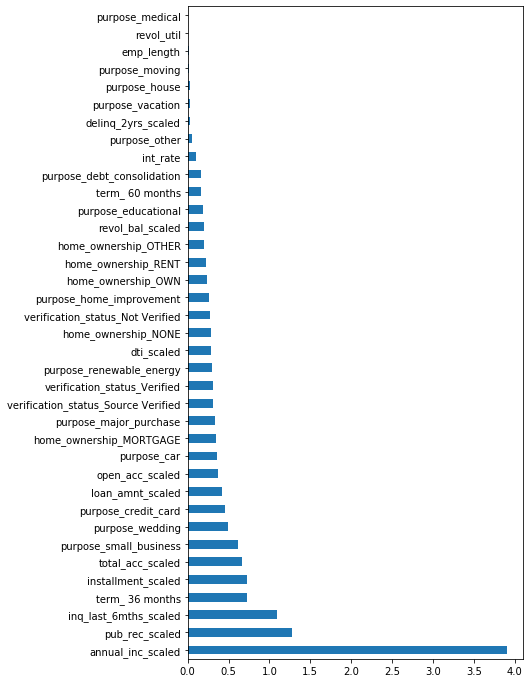

In [26]:
features = loans.drop(['loan_status'], axis=1)
target = loans['loan_status']

lr = LogisticRegression(solver='lbfgs', max_iter=2000)
lr.fit(features, target)

coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0], index=features.columns)
ordered_feature_importance = feature_importance.abs().sort_values(ascending=False)


plt.figure(figsize = (6,12))
ordered_feature_importance.plot.barh()

In [27]:
relevant_features = ordered_feature_importance.iloc[:10].index
relevant_features

Index(['annual_inc_scaled', 'pub_rec_scaled', 'inq_last_6mths_scaled',
       'term_ 36 months', 'installment_scaled', 'total_acc_scaled',
       'purpose_small_business', 'purpose_wedding', 'purpose_credit_card',
       'loan_amnt_scaled'],
      dtype='object')

### Feature engineering 
Using binning

One common way to engineer a feature is using a technique called binning. Binning is when you take a continuous feature, like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'), turning it into a categorical variable.

**This can be useful when there are patterns in the data that are non-linear and you're using a linear model (like logistic regression).**

In [28]:
numerical_df.head()

,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc
0,5000.0,162.87,24000.0,27.65,0.0,1.0,3.0,0.0,13648.0,9.0
1,2500.0,59.83,30000.0,1.00,0.0,5.0,3.0,0.0,1687.0,4.0
2,2400.0,84.33,12252.0,8.72,0.0,2.0,2.0,0.0,2956.0,10.0
3,10000.0,339.31,49200.0,20.00,0.0,1.0,10.0,0.0,5598.0,37.0
5,5000.0,156.46,36000.0,11.20,0.0,3.0,9.0,0.0,7963.0,12.0


Text(0.5, 1.0, 'total_acc')

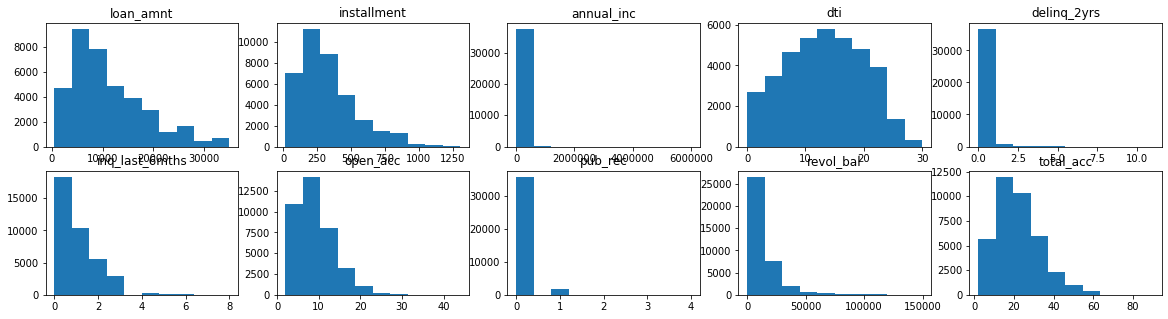

In [29]:
# fig, axes = plt.subplots(nrows= 2, ncols = 5, figsize=(20,5))

# plt.hist(numerical_df['loan_amnt'], ax = axes[0])
# axes[0].set_xlabel('loan_amnt')
# axes[0].set_ylabel('Frequency')


fig, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(nrows=2, ncols=5, figsize=(20,5))

ax0.hist(numerical_df['loan_amnt'])    
ax0.set_title('loan_amnt')

ax1.hist(numerical_df['installment'])    
ax1.set_title('installment')

ax2.hist(numerical_df['annual_inc'])    
ax2.set_title('annual_inc')

ax3.hist(numerical_df['dti'])    
ax3.set_title('dti')

ax4.hist(numerical_df['delinq_2yrs'])    
ax4.set_title('delinq_2yrs')

ax5.hist(numerical_df['inq_last_6mths'])    
ax5.set_title('inq_last_6mths')

ax6.hist(numerical_df['open_acc'])    
ax6.set_title('open_acc')

ax7.hist(numerical_df['pub_rec'])    
ax7.set_title('pub_rec')

ax8.hist(numerical_df['revol_bal'])    
ax8.set_title('revol_bal')

ax9.hist(numerical_df['total_acc'])    
ax9.set_title('total_acc')


In [30]:
numerical_df['annual_inc'].describe().apply(lambda x: format(x, 'f'))

count      37675.000000
mean       69460.964788
std        64620.822987
min         4000.000000
25%        41000.000000
50%        60000.000000
75%        83000.000000
max      6000000.000000
Name: annual_inc, dtype: object

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1be20950>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1bdaf4d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1bd59d90>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1bdaff10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1bc6efd0>],
 'means': []}

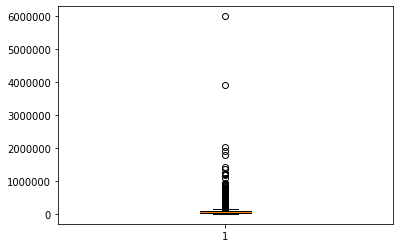

In [31]:
plt.boxplot(numerical_df['annual_inc'])

In [32]:
# loans[loans['annual_inc'] > 3000000]
numerical_df[numerical_df['annual_inc'] > 3000000]

,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc
29708,25000.0,334.08,3900000.0,0.20,0.0,3.0,12.0,0.0,3270.0,32.0
30176,5000.0,167.84,6000000.0,0.01,0.0,1.0,2.0,0.0,1434.0,10.0


https://humansofdata.atlan.com/2018/03/when-delete-outliers-dataset/ 

In [33]:
loans = loans[numerical_df['annual_inc'] < 3000000]
loans.shape

(37673, 38)

In [34]:
numerical_df['delinq_2yrs'].describe()

count    37675.000000
mean         0.147074
std          0.493200
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: delinq_2yrs, dtype: float64

(array([3.357e+04, 3.144e+03, 0.000e+00, 6.560e+02, 0.000e+00, 2.080e+02,
        0.000e+00, 5.800e+01, 0.000e+00, 2.100e+01, 1.000e+01, 0.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.  ,  0.55,  1.1 ,  1.65,  2.2 ,  2.75,  3.3 ,  3.85,  4.4 ,
         4.95,  5.5 ,  6.05,  6.6 ,  7.15,  7.7 ,  8.25,  8.8 ,  9.35,
         9.9 , 10.45, 11.  ]),
 <a list of 20 Patch objects>)

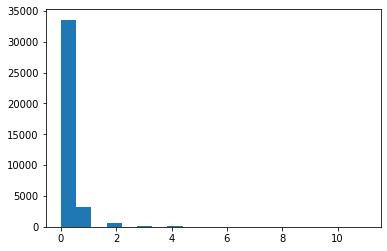

In [35]:
plt.hist(numerical_df['delinq_2yrs'], bins=20)

## Adjusting for collinearity



# Making Predictions 

The algorithm will make predictions about whether or not a loan will be paid off on time, which is contained in the `loan_status` column of the clean dataset.

NOTE: there's a class imbalance in our target column, `loan_status`. There are about 6 times as many loans that were paid off on time (positive case, label of 1) than those that weren't (negative case, label of 0). 

Imbalances can cause issues with many machine learning algorithms, where they appear to have high accuracy, but actually aren't learning from the training data. Because of its potential to cause issues, we need to keep the class imbalance in mind as we build machine learning models.

## Error metric (set up)

Before diving in and selecting an algorithm to apply to the data, I need to select an error metric, that will help me figure out when the model is performing well, and when it's performing poorly. 

It will help determine if the algorithm will make me money or lose me money. Want to fund enough loans that are paid off on time to offset our losses from loans that aren't paid off.

Primarily concerned with 2 types of misclassification:
* **false positives**: we predict that a loan will be paid off on time, but it actually isn't.This costs us money, since we fund loans that lose us money. 
* **false negatives**: we predict that a loan won't be paid off on time, but it actually would be paid off on time. This loses us potential money, since we didn't fund a loan that actually would have been paid off.

Viewing this problem from the standpoint of a conservative investor, we need to treat false positives differently than false negatives. 

A conservative investor would want to minimize risk, and avoid false positives as much as possible. They'd be more okay with missing out on opportunities (false negatives) than they would be with funding a risky loan (false positives).

### Class imbalance

We mentioned earlier that there is a significant class imbalance in the loan_status column. There are 6 times as many loans that were paid off on time (1), than loans that weren't paid off on time (0). This causes a major issue when we use accuracy as a metric. This is because due to the class imbalance, a classifier can predict 1 for every row, and still have high accuracy. 

This is why it's important to always be aware of imbalanced classes in machine learning models, and to adjust your error metric accordingly. In this case, **we don't want to use accuracy, and should instead use metrics that tell us the number of false positives and false negatives**.

This means that we should optimize for:

* **high recall (true positive rate)**
* **low fall-out (false positive rate)**


This divides all the cases where we thought a loan would be paid off but it wasn't by all the loans that weren't paid off. i.e.  **"the percentage of the loans that shouldn't be funded that I would fund"**:

`fpr = fp / (fp + tn)`

This divides all the cases where we thought a loan would be paid off and it was by all the loans that were paid off. i.e **"the percentage of loans that should be funded that I would fund"**:

`tpr = tp / (tp + fn)`

Generally, if we want to reduce false positive rate, true positive rate will also go down. This is because if we want to reduce the risk of false positives, we wouldn't think about funding riskier loans in the first place.

## Logistic Regression with K-fold Cross Validation

K-fold cross validation gives a more realistic depiction of the accuracy of the model and prevents overfitting. 

Overfitting can happen when we generate prediction using the same data that we trained our model on. When we use this to evaluate error, we get an unrealistically high depiction of how accurate the algorithm is, because it already "knows" the correct answers. 

In [37]:
target = loans['loan_status']
features = loans.drop(['loan_status'], axis=1)

# Instantiate model object.
lr = LogisticRegression(solver='lbfgs', max_iter=2000)

# Make predictions using 3-fold cross-validation.
predictions = cross_val_predict(lr, features, target, cv=3)

# Converting predictions to pandas series object
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])


# Rates
tpr = tp  / (tp + fn)
fpr = fp  / (fp + tn)
print("True Positive Rate:", tpr)
print("False Positive Rate", fpr)


True Positive Rate: 0.993903238494821
False Positive Rate 0.9930898321816387


### Using relevant features
Will select the top 10 out of 38 columns (highest coefficients)
    
    

In [38]:
target = loans['loan_status']
features = loans[relevant_features]

# Instantiate model object.
lr = LogisticRegression(solver='lbfgs', max_iter=2000)

# Make predictions using 3-fold cross-validation.
predictions = cross_val_predict(lr, features, target, cv=3)

# Converting predictions to pandas series object
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])


# Rates
tpr = tp  / (tp + fn)
fpr = fp  / (fp + tn)
print("True Positive Rate:", tpr)
print("False Positive Rate", fpr)

True Positive Rate: 0.997541628425331
False Positive Rate 0.9976307996051332


### Penalising the classifier

Even though we're not using accuracy as an error metric, the classifier is, and it isn't accounting for the imbalance in the classes. There are a few ways to get a classifier to correct for imbalanced classes. The two main ways are:

* Use oversampling and undersampling to ensure that the classifier gets input that has a balanced number of each class.
* Tell the classifier to penalize misclassifications of the less prevalent class more than the other class.

With first method have to:
1. Throw out many rows of data
2. Copy rows multiple times
3. Generate fake data

None of these techniques are especially easy. 
Second method is easier to implement using scikit-learn:
* set `class_weight` to parameter `balanced` when creating LogisticRegression instance. Tells scikit-learn to penalize the misclassification of the minority class during the training process. The penalty means that the logistic regression classifier pays more attention to correctly classifying rows where `loan_status` is `0`. This lowers accuracy when loan_status is `1`, but raises accuracy when `loan_status` is `0`.

By setting the `class_weight` parameter to `balanced`, the penalty is set to be inversely proportional to the class frequencies. You can read more about the parameter here. This would mean that for the classifier, correctly classifying a row where `loan_status` is `0` is `6` times more important than correctly classifying a row where `loan_status` is `1`.

In [39]:
# Instantiate model object.
lr = LogisticRegression(class_weight = 'balanced', solver='lbfgs', max_iter=2000)

# Make predictions using 3-fold cross-validation.
predictions = cross_val_predict(lr, features, target, cv=3)

# Converting predictions to pandas series object
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp  / (tp + fn)
fpr = fp  / (fp + tn)
print("True Positive Rate:", tpr)
print("False Positive Rate", fpr)

True Positive Rate: 0.6786416677592763
False Positive Rate 0.6633761105626851


### Manual Penalties

We can try to lower the false positive rate further by assigning a harsher penalty for misclassifying the negative class. While setting `class_weight` to balanced will automatically set a penalty based on the number of `1s` and `0s` in the column, we can also set a manual penalty. In the last screen, the penalty scikit-learn imposed for misclassifying a `0` would have been around `5.89` (since there are `5.89` times as many `1s` as `0s`).

In [40]:
penalty = {
    0: 10,
    1: 1
}

lr = LogisticRegression(class_weight=penalty, solver='lbfgs', max_iter=2000)

predictions = cross_val_predict(lr, features, target, cv=3)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp  / (tp + fn)
fpr = fp  / (fp + tn)
print("True Positive Rate:", tpr)
print("False Positive Rate", fpr)

True Positive Rate: 0.2800249114986233
False Positive Rate 0.25449160908193486


In [41]:
def train_and_test(df, k):
    target = loans(['loan_status'])
    features = loans.drop(['loan_status'], axis=1)
    
    # Instantiating model & implementing k-fold cross validation using k-folds
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    lr = LogisticRegression()
    predictions = cross_val_predict(lr, features, target, cv=kf)
    
    # determining true positive rate and false positive rate
    # converting predictions to pandas series object
    predictions = pd.Series(predictions)
    
    # False positives
    fp_filter = (predictions == 1) & (loans['loans_status'] == 0)
    fp = len(predictions[fp_filter])
    
    # True positives
    tp_filter = (predictions == 1) & (loans['loans_status'] == 1)
    tp = len(predictions[tp_filter])
    
    # False negatives
    fn_filter = (predictions == 0) & (loans['loans_status'] == 1)
    fn = len(predictions[fn_filter])
    
    # True negatives
    tn_filter = (predictions == 0) & (loans['loans_status'] == 0)
    tn = len(predictions[tn_filter])
    
    # Rates
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    
    